# MNIST: Python/NumPy vs. PyTorch

In this notebook, we compare two approaches for training a neural network on the MNIST dataset:

1. **Using Python and NumPy**: 
   - The neural network is implemented from scratch.
   - Includes manual implementation of forward propagation, backward propagation, and parameter updates.

2. **Using PyTorch**: 
   - Utilizes PyTorch's built-in modules for layers, loss functions, and optimization.
   - Simplifies the process while leveraging optimized computations.

**Prerequisite:**

Before running this notebook, **you should download the MNIST dataset** and save it in the `6_MNIST` folder under `data/MNIST/raw`. Ensure that all dataset files are placed correctly so that they can be accessed by the code.

## Python/Numpy

In [ ]:
import numpy as np
import os
from matplotlib import pyplot as plt

# Load MNIST dataset (same as before)
def load_mnist(data_path='data/MNIST/raw'):
    files = {
        'train_images': 'train-images-idx3-ubyte',
        'train_labels': 'train-labels-idx1-ubyte',
        'test_images': 't10k-images-idx3-ubyte',
        'test_labels': 't10k-labels-idx1-ubyte',
    }

    data = {}

    for key, filename in files.items():
        path = os.path.join(data_path, filename)
        if not os.path.exists(path):
            raise FileNotFoundError(f'{filename} not found in {data_path}. Please ensure the files are in the correct location.')

        with open(path, 'rb') as f:
            if 'images' in key:
                f.read(16)  # Skip header
                data_buffer = f.read()
                data[key] = np.frombuffer(data_buffer, dtype=np.uint8).reshape(-1, 28*28)
            else:
                f.read(8)  # Skip header
                data_buffer = f.read()
                data[key] = np.frombuffer(data_buffer, dtype=np.uint8)

    return data['train_images'], data['train_labels'], data['test_images'], data['test_labels']

# Load and preprocess the MNIST data
X_train, y_train, X_test, y_test = load_mnist(data_path='../data/MNIST/raw')

X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_oh = one_hot_encode(y_train)
y_test_oh = one_hot_encode(y_test)


In [13]:
# Activation functions
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.weights = []
        self.biases = []

        for i in range(len(layers) - 1):
            weight = np.random.randn(layers[i], layers[i + 1]) * np.sqrt(2 / layers[i])
            bias = np.zeros((1, layers[i + 1]))
            self.weights.append(weight)
            self.biases.append(bias)

    def forward(self, X):
        activations = [X]
        input = X

        for i in range(len(self.weights)):
            z = np.dot(input, self.weights[i]) + self.biases[i]
            if i < len(self.weights) - 1:
                a = relu(z)
            else:
                a = softmax(z)
            activations.append(a)
            input = a

        return activations

    def backward(self, y, activations):
        deltas = []
        grads_w = []
        grads_b = []

        error = activations[-1] - y
        delta = error
        deltas.append(delta)

        for i in reversed(range(len(self.weights) - 1)):
            delta = np.dot(delta, self.weights[i + 1].T) * relu_derivative(activations[i + 1])
            deltas.insert(0, delta)

        for i in range(len(self.weights)):
            grad_w = np.dot(activations[i].T, deltas[i]) / y.shape[0]
            grad_b = np.sum(deltas[i], axis=0, keepdims=True) / y.shape[0]
            grads_w.append(grad_w)
            grads_b.append(grad_b)

        return grads_w, grads_b

    def update_parameters(self, grads_w, grads_b, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * grads_w[i]
            self.biases[i] -= learning_rate * grads_b[i]

    def train(self, X_train, y_train, epochs, learning_rate, batch_size):
        n_samples = X_train.shape[0]
        history = {'loss': [], 'accuracy': []}

        for epoch in range(epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]

            for start_idx in range(0, n_samples, batch_size):
                end_idx = min(start_idx + batch_size, n_samples)
                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]

                activations = self.forward(X_batch)
                grads_w, grads_b = self.backward(y_batch, activations)
                self.update_parameters(grads_w, grads_b, learning_rate)

            train_loss, train_acc = self.evaluate(X_train, y_train)
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)

            print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

        return history

    def predict(self, X):
        activations = self.forward(X)
        return activations[-1]

    def evaluate(self, X, y):
        output = self.predict(X)
        loss = -np.mean(np.sum(y * np.log(output + 1e-8), axis=1))
        predictions = np.argmax(output, axis=1)
        labels = np.argmax(y, axis=1)
        accuracy = np.mean(predictions == labels)
        return loss, accuracy

In [14]:
# Define the network architecture
layers = [784, 128, 64, 10]

# Create the neural network
nn = NeuralNetwork(layers)

# Train the network using only the training set
history = nn.train(
    X_train, y_train_oh,
    epochs=10, learning_rate=0.1, batch_size=64
)

# Evaluate on the test set
test_loss, test_accuracy = nn.evaluate(X_test, y_test_oh)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10, Loss: 0.1963, Accuracy: 0.9410
Epoch 2/10, Loss: 0.1131, Accuracy: 0.9673
Epoch 3/10, Loss: 0.0861, Accuracy: 0.9748
Epoch 4/10, Loss: 0.0628, Accuracy: 0.9826
Epoch 5/10, Loss: 0.0631, Accuracy: 0.9808
Epoch 6/10, Loss: 0.0463, Accuracy: 0.9865
Epoch 7/10, Loss: 0.0361, Accuracy: 0.9899
Epoch 8/10, Loss: 0.0324, Accuracy: 0.9908
Epoch 9/10, Loss: 0.0304, Accuracy: 0.9916
Epoch 10/10, Loss: 0.0209, Accuracy: 0.9948

Test Loss: 0.0732, Test Accuracy: 0.9775


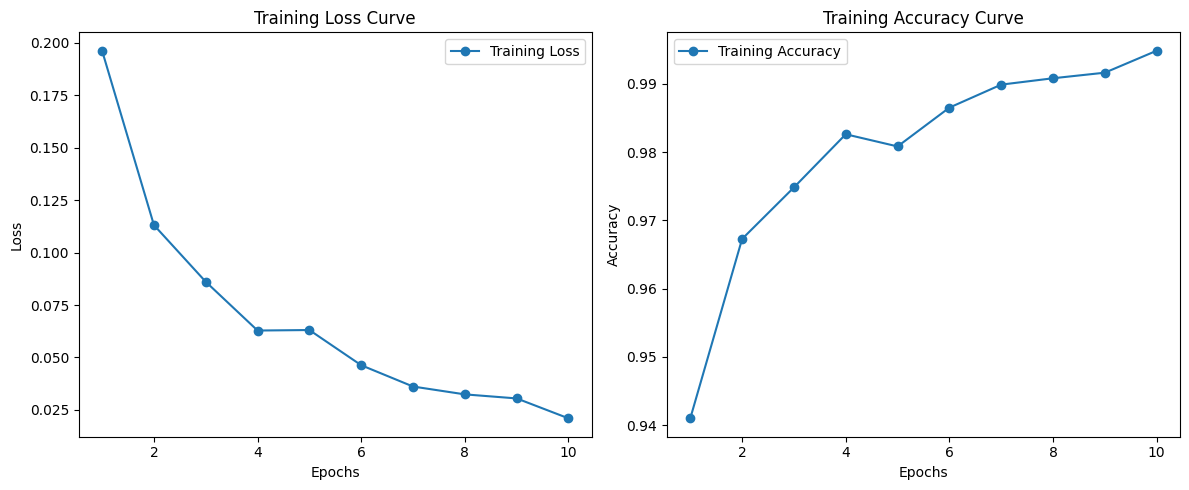


Test Loss: 0.0732, Test Accuracy: 0.9775


In [16]:
# Plotting Training Loss and Accuracy
epochs = range(1, len(history['loss']) + 1)

plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], label='Training Loss', marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], label='Training Accuracy', marker='o')
plt.title('Training Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Final Test Metrics
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


## PyTorch

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

# Create datasets and dataloaders
batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [21]:
class PyTorchNN(nn.Module):
    def __init__(self):
        super(PyTorchNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            # nn.Softmax(dim=1)  # CrossEntropyLoss includes Softmax
        )

    def forward(self, x):
        return self.model(x)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PyTorchNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training settings
num_epochs = 10
history = {'loss': [], 'accuracy': []}
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

    epoch_loss = running_loss / total_train
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

total_time = time.time() - start_time

# Evaluate on the test set
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        test_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_test += y_batch.size(0)
        correct_test += (predicted == y_batch).sum().item()

test_loss /= total_test
test_accuracy = correct_test / total_test

print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Total Training Time: {total_time:.2f} seconds")



Epoch 1/10, Loss: 0.5259, Accuracy: 0.8494
Epoch 2/10, Loss: 0.1924, Accuracy: 0.9434
Epoch 3/10, Loss: 0.1312, Accuracy: 0.9617
Epoch 4/10, Loss: 0.1014, Accuracy: 0.9698
Epoch 5/10, Loss: 0.0820, Accuracy: 0.9750
Epoch 6/10, Loss: 0.0680, Accuracy: 0.9798
Epoch 7/10, Loss: 0.0578, Accuracy: 0.9829
Epoch 8/10, Loss: 0.0487, Accuracy: 0.9851
Epoch 9/10, Loss: 0.0415, Accuracy: 0.9872
Epoch 10/10, Loss: 0.0368, Accuracy: 0.9888

Test Loss: 0.0931, Test Accuracy: 0.9718
Total Training Time: 4.78 seconds


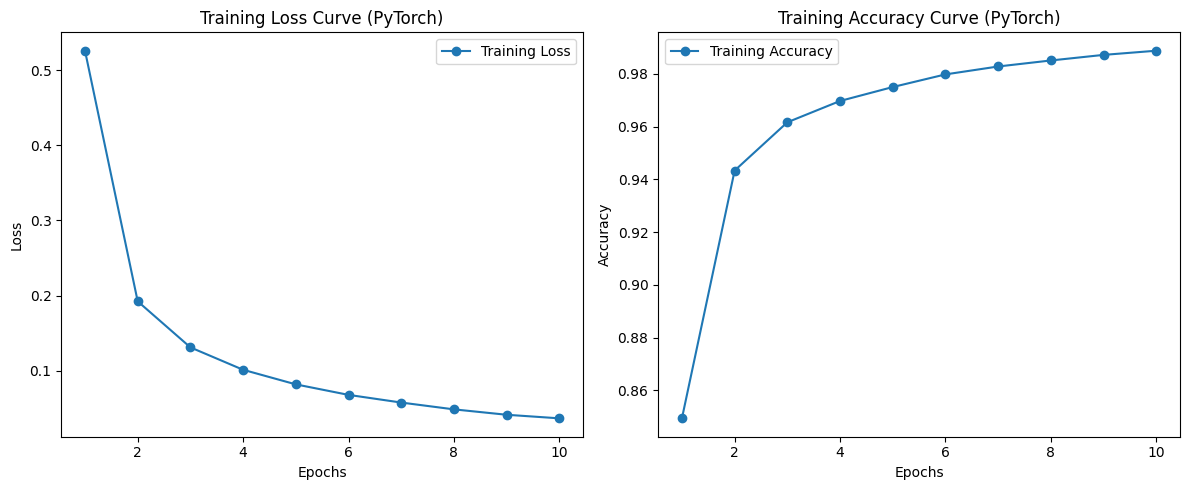

In [23]:
# Plotting Training Loss and Accuracy
epochs = range(1, len(history['loss']) + 1)

plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], label='Training Loss', marker='o')
plt.title('Training Loss Curve (PyTorch)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], label='Training Accuracy', marker='o')
plt.title('Training Accuracy Curve (PyTorch)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

